In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Consumer Discretionary 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services"
1411,1998-12-02,1171.25,223.410004,-12.300735,-12.426011,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1412,1998-12-03,1150.14,219.720001,-12.040563,-12.164699,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1413,1998-12-04,1176.74,223.520004,-10.207476,-11.255803,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1414,1998-12-07,1187.70,226.330002,-7.240649,-8.837154,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
1415,1998-12-08,1181.38,227.729996,-7.513935,-7.775482,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1656.619995,19.548197,33.691106,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7195,2021-11-26,4594.62,1612.869995,16.437110,28.495065,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7196,2021-11-29,4655.27,1639.089966,19.324593,31.459531,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685
7197,2021-11-30,4567.00,1615.829956,17.908879,30.688282,OUTPERFORM,280.126,126.416,186.465,184.449,150.074,123.733,188.685


## Using data after 2010 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
133,2010,1,2010-01-14,1148.46,238.649994,-2.941027,-14.000002,UNDERPERFORM,217.281,111.811,147.935,155.510,116.433,118.460,153.954,3
134,2010,2,2010-02-11,1078.47,230.320007,-9.326551,-19.651138,UNDERPERFORM,217.353,111.683,150.515,158.916,115.187,118.827,153.889,3
135,2010,3,2010-03-11,1150.24,252.570007,-8.476491,-14.876474,UNDERPERFORM,217.403,111.397,151.482,159.927,115.393,118.613,154.230,3
136,2010,4,2010-04-08,1186.44,265.380005,-7.551331,-11.223360,UNDERPERFORM,217.290,111.206,153.708,162.861,114.808,118.712,154.265,3
137,2010,5,2010-05-13,1157.44,264.690002,-12.792152,-14.717915,UNDERPERFORM,217.199,110.989,152.352,161.356,114.465,119.592,153.796,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1462.900024,1.147999,5.918213,OUTPERFORM,273.092,120.078,187.663,186.335,151.745,123.413,185.530,3
272,2021,8,2021-08-12,4460.83,1448.939941,7.276877,20.694706,OUTPERFORM,274.214,120.714,185.440,184.670,148.287,122.967,186.266,3
273,2021,9,2021-09-09,4493.28,1470.270020,15.209058,28.911119,OUTPERFORM,276.590,122.650,183.194,182.511,147.534,124.886,186.661,3
274,2021,10,2021-10-14,4438.26,1476.890015,8.483351,15.471341,OUTPERFORM,278.524,124.413,180.140,179.328,145.114,125.235,187.100,3


In [4]:
original = data[['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]

In [5]:
data.drop(columns=['date','S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
133,1,1148.46,238.649994,-2.941027,-14.000002,217.281,111.811,147.935,155.510,116.433,118.460,153.954,3
134,2,1078.47,230.320007,-9.326551,-19.651138,217.353,111.683,150.515,158.916,115.187,118.827,153.889,3
135,3,1150.24,252.570007,-8.476491,-14.876474,217.403,111.397,151.482,159.927,115.393,118.613,154.230,3
136,4,1186.44,265.380005,-7.551331,-11.223360,217.290,111.206,153.708,162.861,114.808,118.712,154.265,3
137,5,1157.44,264.690002,-12.792152,-14.717915,217.199,110.989,152.352,161.356,114.465,119.592,153.796,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,9
Size in Memory,11.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.34,0.47,2,94
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
durables,float64,0,0,103.43,109.32,126.42,109.35,4.25,142,2
jewelry and watches,float64,0,0,147.94,168.67,187.66,168.30,7.56,142,2
jewelry,float64,0,0,155.51,174.24,186.34,173.55,6.49,143,1
watches,float64,0,0,113.42,124.52,153.74,129.45,11.34,143,1
sporting goods,float64,0,0,108.67,115.56,125.23,115.60,3.50,143,1
"pets, pet products and services",float64,0,0,153.80,168.39,188.69,169.15,8.51,143,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

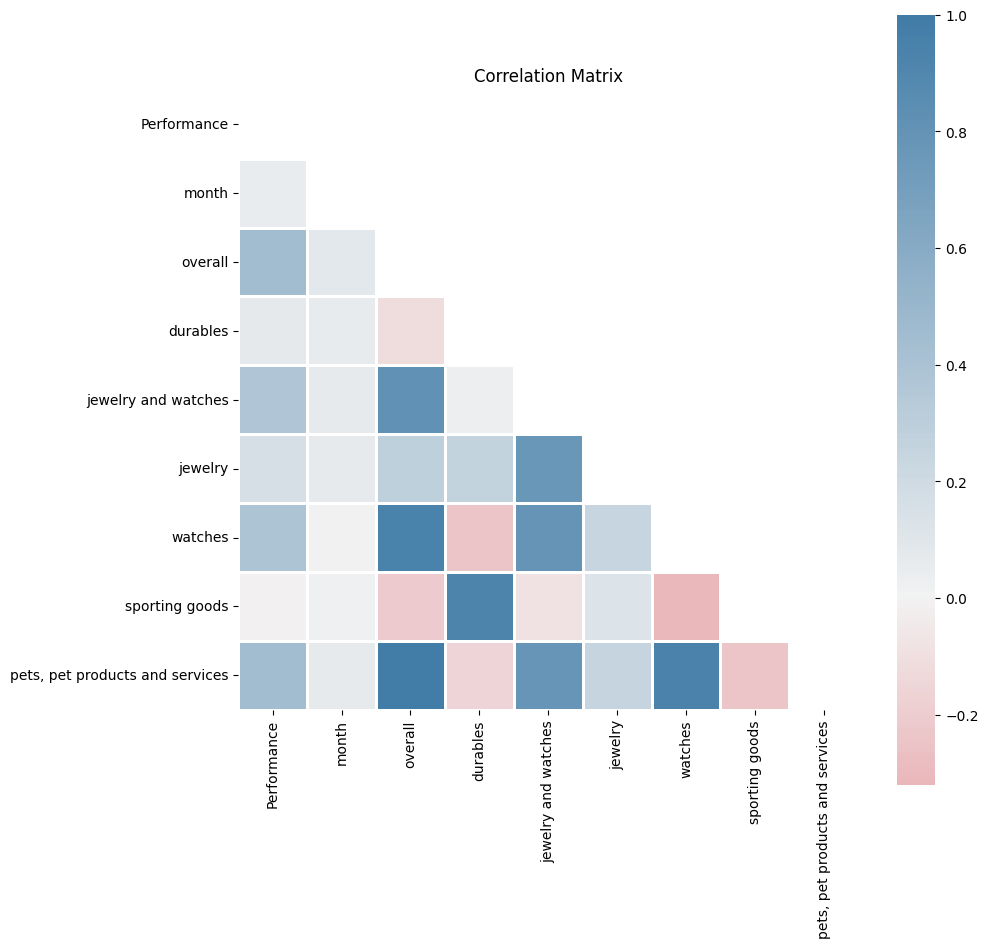

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,11,2578.778695,857.463605,-12.728105,-23.293090,254.386277,106.065607,170.692666,182.172442,138.341812,110.082402,177.124646,3
1,1,1247.632492,155.206469,-26.328049,-12.670859,231.053614,111.734524,159.995119,167.728012,121.488984,116.753739,158.526543,3
2,2,2706.260415,828.421869,5.983797,-0.408138,236.902347,103.732200,165.270196,178.300715,144.514914,111.005498,170.354745,3
3,8,2792.240877,849.957998,-11.434468,-17.101283,259.640054,105.145109,174.096156,184.745338,141.957859,110.930889,170.175960,3
4,12,2187.400283,404.745591,-5.414818,-7.287107,232.657771,106.081314,170.088205,182.242448,130.742980,110.989783,160.956831,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6,2845.874962,706.677263,-16.913511,-22.490853,264.359123,104.679575,173.033292,181.693675,138.910539,111.326716,167.578822,3
9996,7,1184.277291,309.324890,6.578783,-14.422456,217.508261,110.720259,148.413836,170.713647,120.471069,124.013072,160.326678,3
9997,3,2102.246870,876.772761,-12.516790,-15.877808,254.039535,103.275724,160.715114,163.868550,137.149128,113.040255,180.020434,3
9998,6,1638.269748,397.290732,3.729752,1.425516,225.950505,108.714170,145.662596,164.869238,122.046014,112.574721,164.596413,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Consumer Discretionary (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
samples.head()

,Performance,month,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services"
0,0,11,254.386277,106.065607,170.692666,182.172442,138.341812,110.082402,177.124646
1,1,1,231.053614,111.734524,159.995119,167.728012,121.488984,116.753739,158.526543
2,0,2,236.902347,103.732200,165.270196,178.300715,144.514914,111.005498,170.354745
3,0,8,259.640054,105.145109,174.096156,184.745338,141.957859,110.930889,170.175960
4,0,12,232.657771,106.081314,170.088205,182.242448,130.742980,110.989783,160.956831


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.36,0.48,2,6434
month,int64,0,0,1,6,12,6.47,3.45,12,879
overall,float64,0,0,209.92,239.68,292.95,243.12,16.086,10000,1
durables,float64,0,0,100.58,110.029,126.84,109.25,3.95,9998,2
jewelry and watches,float64,0,0,140.90,166.74,197.0055,166.085,8.36,9999,2
jewelry,float64,0,0,156.041,175.51,190.28,174.46,6.36,10000,1
watches,float64,0,0,113.35,129.37,164.60,132.56,12.51,10000,1
sporting goods,float64,0,0,108.21,115.058,126.96,115.22,3.31,10000,1
"pets, pet products and services",float64,0,0,148.53,167.16,195.26,168.92,8.90,9999,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

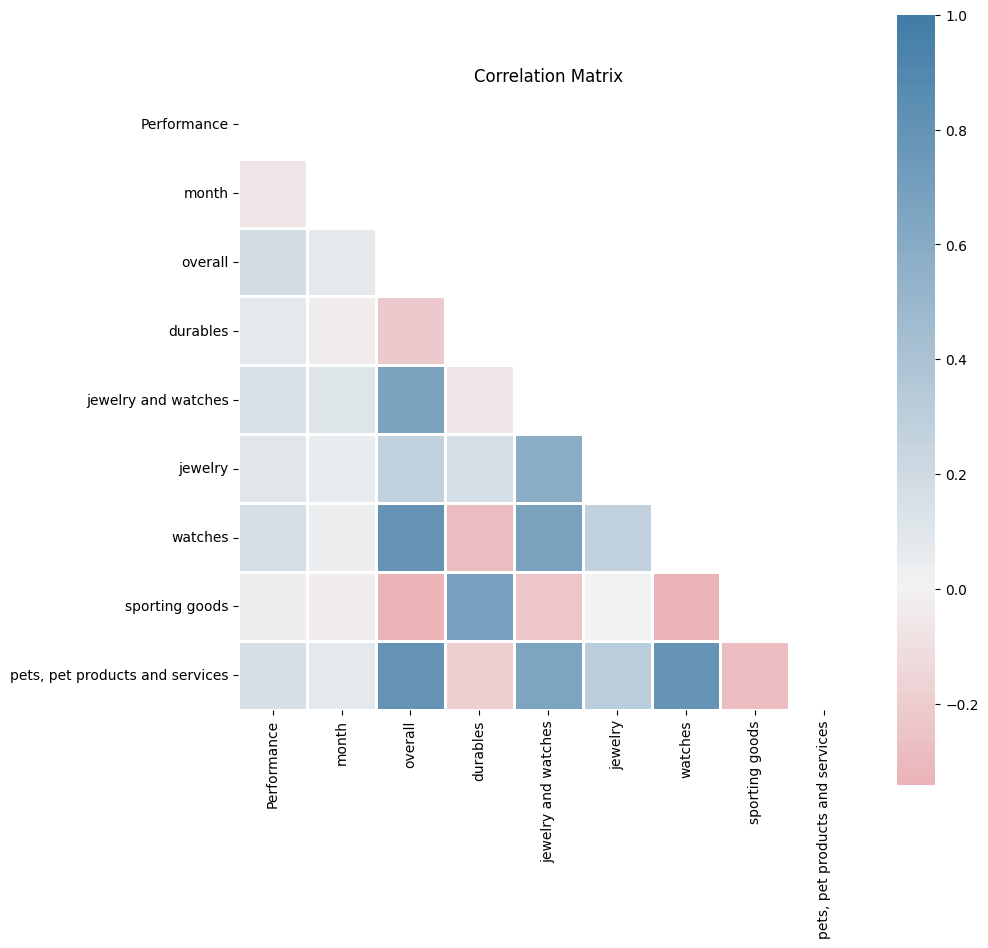

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 6434, 1: 3566})
Counter({0: 6434, 1: 6434})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  254.3862772 ,   106.06560686,   170.69266606, ...,
        15228.99896037, 24503.74439926, 19498.30644951],
       [  231.05361398,   111.7345241 ,   159.99511922, ...,
        14184.2930543 , 19259.2285588 , 18508.56657817],
       [  236.90234654,   103.7322003 ,   165.27019564, ...,
        16041.94996615, 24618.80130822, 18910.31329032],
       ...,
       [  268.07205723,   105.85669105,   176.89161808, ...,
        17711.54565669, 27994.20252362, 20207.24478384],
       [  228.37486308,   110.80004591,   166.76174059, ...,
        15171.42447277, 21839.2034653 , 19988.48028063],
       [  259.4201361 ,   104.07298768,   161.25262701, ...,
        15695.83213916, 25007.9112931 , 19578.83220193]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(12868, 29)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 29)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.665924,0.638273,0.756433,0.691453,0.661486,0.642895,0.742927,0.689301,0.538462,0.369231,0.489796,0.421053
1,DecisionTreeClassifier,0.644086,0.632864,0.678566,0.653765,0.639726,0.63957,0.658057,0.648681,0.587413,0.410714,0.469388,0.438095
2,RandomForestClassifier,0.750322,0.7443,0.755336,0.746305,0.7364,0.746827,0.723862,0.735166,0.664336,0.512821,0.408163,0.454545
3,AdaBoostClassifier,0.61556,0.628266,0.565742,0.594989,0.621697,0.640743,0.572571,0.604742,0.65035,0.491525,0.591837,0.537037
4,GradientBoostingClassifier,0.627219,0.629479,0.616874,0.622842,0.633199,0.641497,0.621771,0.63148,0.657343,0.5,0.571429,0.533333
5,ExtraTreesClassifier,0.78265,0.780681,0.780511,0.776158,0.761579,0.773393,0.747232,0.760088,0.657343,0.5,0.367347,0.423529
6,BaggingClassifier,0.698019,0.708195,0.666749,0.684709,0.683245,0.714791,0.621156,0.664692,0.629371,0.45,0.367347,0.404494
7,SVC,0.60297,0.617636,0.540566,0.57638,0.598694,0.62699,0.50861,0.56163,0.741259,0.636364,0.571429,0.602151
8,GaussianNB,0.583463,0.641279,0.379389,0.476586,0.58595,0.657051,0.378229,0.480094,0.734266,0.703704,0.387755,0.5


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.737333,0.745443,0.729397,0.737333


## Using all data

In [22]:
data = pd.read_csv('../data/S&P 500 Consumer Discretionary 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),S&P 500 Consumer Discretionary (Sector) Outperform/Underperform,overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,1998,12,1998-12-10,1165.02,225.119995,-9.138980,-9.452176,UNDERPERFORM,164.700,126.700,140.200,145.000,123.500,121.100,102.600,3
1,1999,1,1999-01-14,1212.19,241.960007,-11.059996,-10.547519,OUTPERFORM,164.700,126.200,141.300,146.200,124.700,121.200,102.500,3
2,1999,2,1999-02-11,1254.04,253.789993,-11.476613,-7.050255,OUTPERFORM,164.800,125.900,140.200,144.200,123.700,121.500,102.800,3
3,1999,3,1999-03-11,1297.68,270.940002,-11.016635,-7.361438,OUTPERFORM,165.900,125.900,142.000,147.300,123.100,121.400,103.400,3
4,1999,4,1999-04-08,1343.98,282.480011,-6.756119,-3.097663,OUTPERFORM,166.000,125.700,142.500,148.000,123.100,121.000,103.600,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021,7,2021-07-08,4320.82,1462.900024,1.147999,5.918213,OUTPERFORM,273.092,120.078,187.663,186.335,151.745,123.413,185.530,3
272,2021,8,2021-08-12,4460.83,1448.939941,7.276877,20.694706,OUTPERFORM,274.214,120.714,185.440,184.670,148.287,122.967,186.266,3
273,2021,9,2021-09-09,4493.28,1470.270020,15.209058,28.911119,OUTPERFORM,276.590,122.650,183.194,182.511,147.534,124.886,186.661,3
274,2021,10,2021-10-14,4438.26,1476.890015,8.483351,15.471341,OUTPERFORM,278.524,124.413,180.140,179.328,145.114,125.235,187.100,3


In [23]:
original = data[['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
data.drop(columns=['date','S&P 500 Consumer Discretionary (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Consumer Discretionary (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Consumer Discretionary (Sector),S&P 500 Performance (%),S&P 500 Consumer Discretionary (Sector) Performance (%),overall,durables,jewelry and watches,jewelry,watches,sporting goods,"pets, pet products and services",dow
0,3,1403.371667,740.249636,-5.518130,-4.800376,234.385007,112.380672,161.752766,175.392694,122.074391,115.999649,162.857799,3
1,6,1115.408449,246.341393,3.142609,7.564665,179.123082,120.391413,135.740270,138.394163,121.980585,116.520641,115.757639,3
2,8,2804.675272,245.788680,-11.053341,-10.769021,225.364982,113.837104,168.611859,179.468887,117.235146,117.347480,157.718867,3
3,6,1202.127458,270.038404,-15.763206,-9.749145,209.616614,111.464129,133.702180,159.205199,121.494392,120.070814,165.677921,3
4,9,1553.145553,368.379965,-0.388204,47.973901,238.981493,111.877839,141.060624,183.004430,121.158244,118.524456,167.172555,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,1155.276728,234.164794,-15.647366,-18.790521,206.505696,114.080127,141.173879,165.936081,113.331008,118.293176,156.158029,3
9996,6,1406.649805,201.882554,3.737252,20.736954,181.334222,123.988371,132.277102,133.303961,121.074245,115.804501,131.447760,3
9997,12,2696.898549,718.452263,-3.738993,-12.797551,228.662937,104.687299,172.277366,179.801608,120.636974,110.606585,164.963067,3
9998,5,2319.062054,645.992671,-8.250157,-7.271569,231.911028,108.296279,161.096976,136.315708,115.529954,111.284664,129.783102,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Consumer Discretionary (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','durables',\
                'jewelry and watches','jewelry','watches','sporting goods','pets, pet products and services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.637103,0.633026,0.651697,0.641801,0.644436,0.647275,0.659415,0.653289,0.634058,0.530769,0.633028,0.577406
1,DecisionTreeClassifier,0.599665,0.597148,0.606362,0.601009,0.601753,0.608597,0.605401,0.606995,0.51087,0.402985,0.495413,0.444444
2,RandomForestClassifier,0.674073,0.675868,0.666956,0.670293,0.677973,0.692126,0.659415,0.675375,0.644928,0.540741,0.669725,0.598361
3,AdaBoostClassifier,0.659393,0.662943,0.64882,0.65571,0.661966,0.674491,0.646662,0.660283,0.630435,0.525547,0.66055,0.585366
4,GradientBoostingClassifier,0.665587,0.669543,0.654159,0.661698,0.67378,0.68824,0.654164,0.670769,0.637681,0.534884,0.633028,0.579832
5,ExtraTreesClassifier,0.679219,0.680115,0.673825,0.675165,0.679497,0.693701,0.660915,0.676911,0.666667,0.565891,0.669725,0.613445
6,BaggingClassifier,0.635963,0.653812,0.573019,0.60938,0.652058,0.680723,0.593398,0.634068,0.644928,0.54955,0.559633,0.554545
7,SVC,0.653487,0.662787,0.62557,0.64356,0.661204,0.680195,0.628657,0.653411,0.681159,0.585366,0.66055,0.62069
8,GaussianNB,0.630048,0.653563,0.55392,0.599531,0.639863,0.675725,0.55964,0.612228,0.630435,0.530973,0.550459,0.540541
